In [33]:
import numpy as np
import gym
import gym.spaces
import torch
import torch.optim as optim
import torch.nn as nn

from gym_utils import get_action_bound, get_state_dimension, get_action_dimension
from replay_buffer import ReplayBuffer
from model import VCritic, SoftQCritic, SACActor, NormalizedActions
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
mean_lambda = 1e-3
std_lambda = 1e-3
z_lambda = 0.0

cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")

In [35]:
def plot(rewards):
    clear_output(True)
    rewards = np.array(rewards)
    plt.plot(rewards)
    plt.show()

In [36]:
def get_loss(val, next_val):
    criterion = nn.MSELoss()
    
    return criterion(val, next_val)

In [37]:
def send_to_device(s, a, r, next_s, done):
    s = torch.FloatTensor(s).to(device)
    a = torch.FloatTensor(a).to(device)
    r = torch.FloatTensor(r).unsqueeze(1).to(device)
    next_s = torch.FloatTensor(next_s).to(device)
    done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    return s, a, r, next_s, done

In [38]:
def run_experiment(actor, buffer, v_critic, target_v_critic, q_critic, env, gamma, v_optimizer, q_optimizer, actor_optimizer, max_steps, n_epi, evaluation=False):
    global_step = 0
    final_r = []
    #number of episodes
    for i in trange(n_epi):
        state = env.reset()
        done = False
        total_reward = 0
        #max number of steps per episode
        for _ in range(max_steps):
            action = actor.get_action(state)
            #action = np.clip(action.flatten(), -2., 2.)
            next_state, reward, done, _ = env.step(action)
            if not evaluation:
                buffer.add(state, action, reward, next_state, done)

                if 256 < len(buffer):
                    s, a, r, next_s, d = buffer.sample_batch(256)
                    s, a, r, next_s, d = send_to_device(s, a, r, next_s, d) 

                    q = q_critic(s, a)
                    v = v_critic(s)
                    new_a, log_prob, z, mean, log_std = actor.evaluate(s)

                    target_v = target_v_critic(next_s)
            
                    next_q = r + (1 - d) * gamma * target_v 
                    q_loss = get_loss(q, next_q.detach())

                    new_q = q_critic(s, new_a)
                    next_v = new_q - log_prob
                    v_loss = get_loss(v, next_v.detach())

                    log_prob_target = new_q - v
                    actor_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

                    #regularization losses
                    mean_loss = mean_lambda * mean.pow(2).mean()
                    std_loss = std_lambda * log_std.pow(2).mean()
                    z_loss = z_lambda * z.pow(2).sum(1).mean()
                    actor_loss += mean_loss + std_loss + z_loss

                    v_critic.train(v_loss, v_optimizer)
                    q_critic.train(q_loss, q_optimizer)
                    actor.train(actor_loss, actor_optimizer)
                    
                    #soft update (can be done using soft-update function in model)
                    for target_param, param in zip(target_v_critic.parameters(), v_critic.parameters()):
                        target_param.data.copy_(target_param.data * (1.0 - 5*1e-3) + param.data * 5*1e-3)

            global_step += 1
            state = next_state
            total_reward += reward
            
            if global_step%500==0:
                plot(final_r)

            if done:
                break
        
        final_r.append(total_reward)

    return final_r


In [39]:

def main(arg):
    train_rewards = []
    num_steps = []
    test_rewards = []

    for i in range(1):
        env = NormalizedActions(gym.make(arg.env))
        env.seed(np.random.randint(12345))
        a_dim = get_action_dimension(env)            
        s_dim = get_state_dimension(env)

        buffer = ReplayBuffer(size=arg.buffer, a_dim=a_dim, a_dtype=np.float32, s_dim=s_dim, s_dtype=np.float32, store_mu=False)

        v_critic = VCritic().to(device)
        target_v_critic = VCritic().to(device)

        softq_critic = SoftQCritic().to(device)

        SAC_actor = SACActor().to(device)

        v_optimizer = optim.Adam(v_critic.parameters(), lr=3e-4)
        q_optimizer = optim.Adam(softq_critic.parameters(), lr=3e-4)
        actor_optimizer = optim.Adam(SAC_actor.parameters(), lr=3e-4)

        rewards = run_experiment(SAC_actor, buffer, v_critic, target_v_critic, softq_critic, env, arg.discount, v_optimizer, q_optimizer, actor_optimizer, arg.max, arg.n_epi)

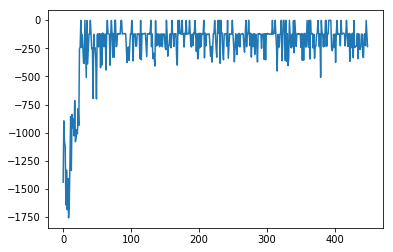


 45%|████▌     | 450/1000 [13:22<16:21,  1.78s/it]

KeyboardInterrupt: 

In [40]:
if __name__ == '__main__':
    from argparse import ArgumentParser
    argparser = ArgumentParser()
    argparser.add_argument('-b', '--buffer', default=int(1000000), help='Buffer size (default: 1000000).')
    
   
    argparser.add_argument('-f', '--freq', default=int(500), help='An evaluation episode is done at every _freq_ step.')
    argparser.add_argument('-m', '--max', default=int(500), help='Max number of steps (default: 500).')
    argparser.add_argument('-n', '--n_exp', default=int(20), help='Number of experiments (default: 20).')
    argparser.add_argument('-d', '--discount', default=float(0.99), help='Discount factor, gamma (default: 0.99).')
    argparser.add_argument('-e', '--env', default=str('Pendulum-v0'), help='ID of gym environment (default: Pendulum-v0).')
    argparser.add_argument('-p', '--n_epi', default=int(1000), help='Number of episodes (defualt: 1000).')
    arg = argparser.parse_args()
    main(arg)